#***Part #1***

In [58]:
from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import nltk
nltk.download('reuters')
from nltk.corpus import reuters
import numpy as np
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

np.random.seed(0)
random.seed(0)
!unzip -nq /root/nltk_data/corpora/reuters.zip -d /root/nltk_data/corpora

[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


In [59]:
START_TOKEN = '<START>'
END_TOKEN = '<END>'

def read_corpus(category="crude"):
    """ Read files from the specified Reuter's category.
        Params:
            category (string): category name
        Return:
            list of lists, with words from each of the processed files
    """
    files = reuters.fileids(category)
    return [[START_TOKEN] + [w.lower() for w in list(reuters.words(f))] + [END_TOKEN] for f in files]

In [60]:
def distinct_words(corpus):
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents
        Return:
            corpus_words (list of strings): sorted list of distinct words across the corpus
            num_corpus_words (integer): number of distinct words across the corpus
    """
    corpus_words = []
    num_corpus_words = -1
    
    # ------------------
    # Write your implementation here.
    
    corpus_words = [y for x in corpus for y in x]
    corpus_words = sorted(set(corpus_words))
    num_corpus_words = len(corpus_words)
    # ------------------

    return corpus_words, num_corpus_words

In [61]:
# Define toy corpus
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
test_corpus_words, num_corpus_words = distinct_words(test_corpus)

# Correct answers
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
ans_num_corpus_words = len(ans_test_corpus_words)

# Test correct number of words
assert(num_corpus_words == ans_num_corpus_words), "Incorrect number of distinct words. Correct: {}. Yours: {}".format(ans_num_corpus_words, num_corpus_words)

# Test correct words
assert (test_corpus_words == ans_test_corpus_words), "Incorrect corpus_words.\nCorrect: {}\nYours:   {}".format(str(ans_test_corpus_words), str(test_corpus_words))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


In [62]:
def compute_co_occurrence_matrix(corpus, window_size=4):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).
    
        Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
              number of co-occurring words.
              
              For example, if we take the document "<START> All that glitters is not gold <END>" with window size of 4,
              "All" will co-occur with "<START>", "that", "glitters", "is", and "not".
    
        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
        Return:
            M (a symmetric numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): 
                Co-occurence matrix of word counts. 
                The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
            word2ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
    """
    words, num_words = distinct_words(corpus)
    M = None
    word2ind = {}
    
    # ------------------
    # Write your implementation here.

    M = np.zeros((num_words, num_words))
    word2ind = {x:idx for idx,x in enumerate(words)}

    for corpus_words in corpus:
      for (word, co) in [(corpus_words[idx], corpus_words[max(0,idx-window_size):idx]+corpus_words[idx+1:min(len(corpus_words), idx+window_size+1)]) for idx in range(len(corpus_words))]:
        for w in co: M[word2ind[word]][word2ind[w]] = 1
    
    return M, word2ind

In [63]:
# Define toy corpus and get student's co-occurrence matrix
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)

# Correct M and word2ind
M_test_ans = np.array( 
    [[0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,],
     [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,],
     [1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,],
     [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,],
     [0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,],
     [1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,]]
)
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
word2ind_ans = dict(zip(ans_test_corpus_words, range(len(ans_test_corpus_words))))

# Test correct word2ind
assert (word2ind_ans == word2ind_test), "Your word2ind is incorrect:\nCorrect: {}\nYours: {}".format(word2ind_ans, word2ind_test)

# Test correct M shape
assert (M_test.shape == M_test_ans.shape), "M matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(M_test.shape, M_test_ans.shape)

# Test correct M values
for w1 in word2ind_ans.keys():
    idx1 = word2ind_ans[w1]
    for w2 in word2ind_ans.keys():
        idx2 = word2ind_ans[w2]
        student = M_test[idx1, idx2]
        correct = M_test_ans[idx1, idx2]
        if student != correct:
            print("Correct M:")
            print(M_test_ans)
            print("Your M: ")
            print(M_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix M. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student, correct))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


In [64]:
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
        Params:
            M (numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """    
    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    
    # ------------------
    # Write your implementation here.
    svd = TruncatedSVD(n_components=k, n_iter=n_iters)
    M_reduced = svd.fit_transform(M)
    # ------------------

    print("Done.")
    return M_reduced

In [65]:
# Define toy corpus and run student code
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)
M_test_reduced = reduce_to_k_dim(M_test, k=2)

# Test proper dimensions
assert (M_test_reduced.shape[0] == 10), "M_reduced has {} rows; should have {}".format(M_test_reduced.shape[0], 10)
assert (M_test_reduced.shape[1] == 2), "M_reduced has {} columns; should have {}".format(M_test_reduced.shape[1], 2)

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

Running Truncated SVD over 10 words...
Done.
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


In [66]:
def plot_embeddings(M_reduced, word2ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2ind.
        Include a label next to each point.
        
        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , 2)): matrix of 2-dimensioal word embeddings
            word2ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """

    # ------------------
    # Write your implementation here.
    for (word, coord) in [(word, M_reduced[word2ind[word]]) for word in words]:
      plt.scatter(coord[0], coord[1], marker='x', color='red')
      plt.text(coord[0], coord[1], word, fontsize=9)
    plt.show()

    # ------------------

--------------------------------------------------------------------------------
Outputted Plot:


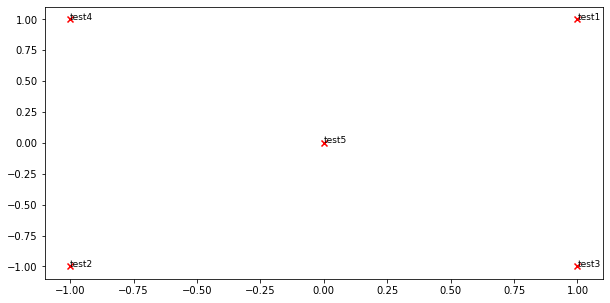

--------------------------------------------------------------------------------


In [67]:
print ("-" * 80)
print ("Outputted Plot:")

M_reduced_plot_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2ind_plot_test = {'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4}
words = ['test1', 'test2', 'test3', 'test4', 'test5']
plot_embeddings(M_reduced_plot_test, word2ind_plot_test, words)

print ("-" * 80)

**Answer 1.5: Co-Occurrence Plot Analysis**

아래 코드를 실행해보면 crude 는 다른 oil과 관련이 있는 것들과 같이 clustering 되는 것을 볼 수 있다. 반면 굉장히 관련이 깊은 oil은 혼자 동떨어져있다. 

이러한 결과가 나온 이유는 "crude (oil) corpus"에서 보통 crude oil을 crude로만 사용하고 oil을 생략하는 경우가 많아서 oil의 Co-Occurrence 빈도수가 적어 oil만 따로 cluster 된 것으로 보인다.

Running Truncated SVD over 8185 words...
Done.


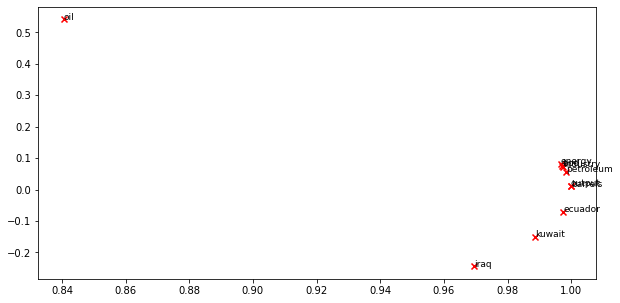

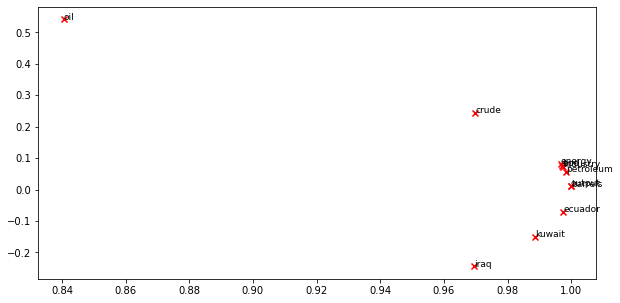

In [68]:
# -----------------------------
# Run This Cell to Produce Your Plot
# ------------------------------
reuters_corpus = read_corpus()
M_co_occurrence, word2ind_co_occurrence = compute_co_occurrence_matrix(reuters_corpus)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting

words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']

plot_embeddings(M_normalized, word2ind_co_occurrence, words)

# ------------My Code--------------
words = ['crude', 'barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']

plot_embeddings(M_normalized, word2ind_co_occurrence, words)
# ---------------------------------

#***Part #2***

In [69]:
def load_embedding_model():
    """ Load GloVe Vectors
        Return:
            wv_from_bin: All 400000 embeddings, each lengh 200
    """
    import gensim.downloader as api
    wv_from_bin = api.load("glove-wiki-gigaword-200")
    print("Loaded vocab size %i" % len(wv_from_bin.vocab.keys()))
    return wv_from_bin
wv_from_bin = load_embedding_model()

Loaded vocab size 400000


In [70]:
def get_matrix_of_vectors(wv_from_bin, required_words=['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']):
    """ Put the GloVe vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 400000 GloVe vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 200) containing the vectors
            word2ind: dictionary mapping each word to its row number in M
    """
    import random
    words = list(wv_from_bin.vocab.keys())
    print("Shuffling words ...")
    random.seed(224)
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2ind and matrix M..." % len(words))
    word2ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.word_vec(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        if w in words:
            continue
        try:
            M.append(wv_from_bin.word_vec(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2ind

In [71]:
M, word2ind = get_matrix_of_vectors(wv_from_bin)
M_reduced = reduce_to_k_dim(M, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced, axis=1)
M_reduced_normalized = M_reduced / M_lengths[:, np.newaxis] # broadcasting

Shuffling words ...
Putting 10000 words into word2ind and matrix M...
Done.
Running Truncated SVD over 10010 words...
Done.


**Answer 2.1: GloVe Plot Analysis**

이번 코드는 위에서와 다른 것이 Shuffling words를 한 후 random하게 sampling 했다는 것이다. 즉, window를 통해 Co-Occurrence를 따진 것이 아니라 자주 나오는 단어들의 빈도수를 기준으로 판단한 것이다. 

bpd는 분명 oil이나 ecuador 등과 관련이 깊은 단어이지만 그 사용 빈도 자체는 많지 않기 때문에 같이  clustering 되지 않고 따로 clustering 된 것이다.

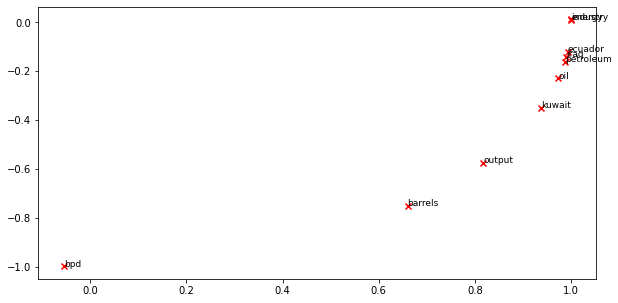

In [72]:
words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']
plot_embeddings(M_reduced_normalized, word2ind, words)

**Answer 2.2: Words with Multiple Meanings**

Polysemes and homonyms 에서 하나의 의미만 뽑히는 이유는 하나의 단어에 대해 하나의 word vector만을 갖기 때문이다. 즉, 단어 하나 당 하나의 뜻만을 표현할 수 있기 때문에 top 10 similar words 도 모두 그 하나의 뜻과 관련된 주위 단어들만 선택이 될 수밖에 없다.

In [73]:
print('10 Similar words to "leaves":', wv_from_bin.most_similar('leaves'))
# ------------------
# Write your implementation here.
print('10 Similar words to "like":', wv_from_bin.most_similar('like'))
print('10 Similar words to "fair":', wv_from_bin.most_similar('fair'))
print('10 Similar words to "lie":', wv_from_bin.most_similar('lie'))
print('10 Similar words to "mean":', wv_from_bin.most_similar('mean'))

# ------------------

10 Similar words to "leaves": [('ends', 0.6128067970275879), ('leaf', 0.6027014851570129), ('stems', 0.5998532176017761), ('takes', 0.5902854800224304), ('leaving', 0.5761634111404419), ('grows', 0.5663397312164307), ('flowers', 0.5600922107696533), ('turns', 0.5536050796508789), ('leave', 0.5496848821640015), ('goes', 0.5434924960136414)]
10 Similar words to "like": [('such', 0.81000816822052), ('even', 0.8047264814376831), ('come', 0.782503604888916), ('well', 0.7741074562072754), ('other', 0.7734431624412537), ('?', 0.7713761329650879), ("n't", 0.7688160538673401), ('you', 0.759581446647644), ('so', 0.7566972970962524), ('things', 0.74755859375)]
10 Similar words to "fair": [('good', 0.582463264465332), ('ensure', 0.5500814914703369), ('reasonable', 0.547465980052948), ('honest', 0.5450991988182068), ('should', 0.5396431684494019), ('unfair', 0.5184458494186401), ('judged', 0.5102013349533081), ('benefit', 0.5064212083816528), ('sure', 0.5060824751853943), ('kind', 0.504383683204650

**Answer 2.3: Synonyms & Antonyms**

Antonyms 같은 경우 반대의 의미를 부각하기 위해 같이 쓰거나, 서로 들어가는 자리에 대신 들어가도 되는 경우가 많기 때문에 (ex I like/hate it) 어느 정도의 관련성(similarity)가 있다.

반면, small과 verged 와 같이 완전히 동떨어진 단어들의 경우 두 단어 간의 관련성(similarity) 가 적기 때문에 오히려 더 멀게 판단하는 경우가 존재하는 것 같다.

In [74]:
print('Cosine distance between "happy" and "sad":', wv_from_bin.distance('happy', 'sad'))
print('Cosine distance between "happy" and "cheerful":', wv_from_bin.distance('happy', 'cheerful'))
# ------------------
# Write your implementation here.

d1 = wv_from_bin.distance('small', 'big')
print('Cosine distance between "small" and "big":', d1)
for (key, val) in word2ind.items():
  d2 = wv_from_bin.distance('small', key)
  if d1 < d2:
    print('Cosine distance between "small" and "{}":'.format(key), d2)
    break

# ------------------

Cosine distance between "happy" and "sad": 0.4040136933326721
Cosine distance between "happy" and "cheerful": 0.5172466933727264
Cosine distance between "small" and "big": 0.3511464595794678
Cosine distance between "small" and "verged": 1.1378346979618073


**Answer 2.4: Analogies with Word Vectors**

$x = w+k-m$

In [75]:
# Run this cell to answer the analogy -- man : king :: woman : x
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'king'], negative=['man']))

[('queen', 0.6978678703308105),
 ('princess', 0.6081745028495789),
 ('monarch', 0.5889754891395569),
 ('throne', 0.5775108933448792),
 ('prince', 0.5750998854637146),
 ('elizabeth', 0.546359658241272),
 ('daughter', 0.5399125814437866),
 ('kingdom', 0.5318052768707275),
 ('mother', 0.5168544054031372),
 ('crown', 0.5164472460746765)]


**Answer 2.5: Finding Analogies**

teach하는 사람이 teacher이니까 learn 하는 사람은 student가 나올 것이다. 라고 예상하고 돌린 결과 learned, student 등 관련 정보가 제대로 나왔다.

In [76]:
# ------------------
# Write your implementation here.
pprint.pprint(wv_from_bin.most_similar(positive=['learn', 'teacher'], negative=['teach']))

# ------------------

[('learned', 0.6538822650909424),
 ('student', 0.6350857019424438),
 ('learning', 0.6244571208953857),
 ('mother', 0.6107984781265259),
 ('friend', 0.5857067704200745),
 ('father', 0.5720540285110474),
 ('teachers', 0.5643230080604553),
 ('parents', 0.5625167489051819),
 ('know', 0.5513224601745605),
 ('woman', 0.5500799417495728)]


**Answer 2.6: Incorrect Analogy**

Expected - hand : finger = foot : toe

손 : 손가락 = 발 : 발가락 을 예상하고 넣어본 결과 완전 예상하지 못한 이상한 결과가 나왔다.

In [77]:
# ------------------
# Write your implementation here.
pprint.pprint(wv_from_bin.most_similar(positive=['foot', 'finger'], negative=['hand']))

# ------------------

[('15,000-square', 0.5046214461326599),
 ('700-square', 0.49830538034439087),
 ('45,000-square', 0.4973765015602112),
 ('thumb', 0.49426332116127014),
 ('9,000-square', 0.49387872219085693),
 ('27,000-square', 0.48809075355529785),
 ('50,000-square', 0.4873480796813965),
 ('feet', 0.4864470958709717),
 ('6,000-square', 0.4857812523841858),
 ('3,500-square', 0.4834233522415161)]


**Answer 2.7: Guided Analysis of Bias in Word Vectors**

(a) the terms which are most similar to "woman" and "worker" and most dissimilar to "man": employee, workers, nurse, pregnant, mother, employer, teacher, child, homemaker, nurses

(b) the terms which are most similar to "man" and "worker" and most dissimilar to "woman": workers, employee, working, laborer, unemployed, job, work, mechanic, worked, factory

female-associated words인 (a)의 경우 nurses, mother 과 같은 주로 여성들이 많이 하는 직업과 관련된 것들이 결과로 나왔고, male-associated words인 (b)의 경우 mechanic, factory 등 남성들이 많이 하는 직업과 관련된 것들이 결과로 나왔다.

즉, gender에 대해 biased 되어 있는 직업들이 있다다.

In [78]:
# Run this cell
# Here `positive` indicates the list of words to be similar to and `negative` indicates the list of words to be
# most dissimilar from.
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'worker'], negative=['man']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['man', 'worker'], negative=['woman']))

[('employee', 0.6375863552093506),
 ('workers', 0.6068919897079468),
 ('nurse', 0.5837947726249695),
 ('pregnant', 0.5363885164260864),
 ('mother', 0.5321309566497803),
 ('employer', 0.5127025842666626),
 ('teacher', 0.5099576711654663),
 ('child', 0.5096741914749146),
 ('homemaker', 0.5019454956054688),
 ('nurses', 0.4970572590827942)]

[('workers', 0.6113258004188538),
 ('employee', 0.5983108282089233),
 ('working', 0.5615328550338745),
 ('laborer', 0.5442320108413696),
 ('unemployed', 0.5368517637252808),
 ('job', 0.5278826951980591),
 ('work', 0.5223963260650635),
 ('mechanic', 0.5088937282562256),
 ('worked', 0.505452036857605),
 ('factory', 0.4940453767776489)]


**Answer 2.8: Independent Analysis of Bias in Word Vectors**

female : doctor = male : ? / male : doctor = female : ?  
로 돌려본 결과 전자의 경우 pharmacist, psychiatrist 등이, 후자의 경우 surgeon, nurse 등이 gender-biased 된 것을 확인할 수 있었다. 

In [79]:
# ------------------
# Write your implementation here.

pprint.pprint(wv_from_bin.most_similar(positive=['male', 'doctor'], negative=['female']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['female', 'doctor'], negative=['male']))

# ------------------

[('physician', 0.6771864891052246),
 ('doctors', 0.6346237659454346),
 ('patient', 0.6174558401107788),
 ('hospital', 0.6015103459358215),
 ('medical', 0.5913147330284119),
 ('dr.', 0.5892403721809387),
 ('surgeon', 0.5797871351242065),
 ('nurse', 0.5776176452636719),
 ('pharmacist', 0.5564133524894714),
 ('psychiatrist', 0.5445657968521118)]

[('physician', 0.6877284049987793),
 ('surgeon', 0.6331759095191956),
 ('nurse', 0.628593921661377),
 ('dr.', 0.6198309063911438),
 ('doctors', 0.613690197467804),
 ('medical', 0.6102843284606934),
 ('hospital', 0.5799989700317383),
 ('dentist', 0.5427913665771484),
 ('patient', 0.5348472595214844),
 ('nurses', 0.5320171117782593)]


**Answer 2.9: Thinking About Bias**

word vectors를 만들 때 성/종교/인종 차별적인 데이터들을 통해 학습할 경우 bias가 생길 수 있다. 예를 들어 doctor - nurse 처럼 대표적인 gender-biase한 정보를 가지고 있는 데이터를 통해 학습한 word vector들 같은 경우 2.8에서 확인한 것처럼 word vectors도 gender-biased 되는 것을 확인할 수 있다.

In [80]:
from google.colab import drive, files
from requests import get
from urllib.parse import unquote

drive.mount('/mnt/')
filename = unquote(get('http://172.28.0.12:9000/api/sessions').json()[0]['name'])
filepath = f'/mnt/My Drive/NLP/{filename}'
output_file = '/content/Assignment1.html'

!jupyter nbconvert '{filepath}' --to html --output '{output_file}'
files.download(output_file) 

Drive already mounted at /mnt/; to attempt to forcibly remount, call drive.mount("/mnt/", force_remount=True).
[NbConvertApp] Converting notebook /mnt/My Drive/NLP/NLP_Assignment_1.ipynb to html
[NbConvertApp] Writing 721096 bytes to /content/Assignment1.html


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>